In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (13.0, 5.0)

# Задача регрессии - это предсказание некоторого вещественного числа 

будем предсказывать функцию sin(y)

### Train dataset

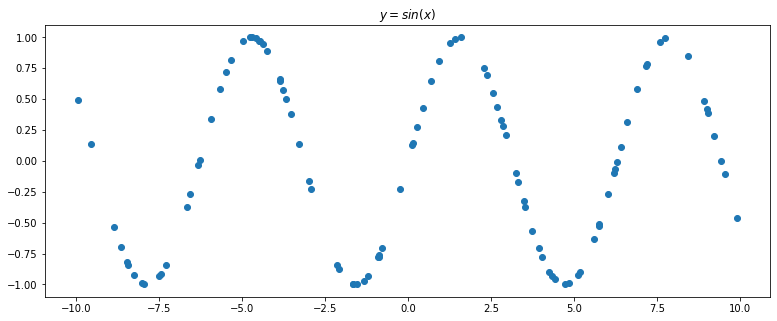

In [4]:
# задаем х
x_train = torch.rand(100) # точки из равномерного распределения от 0 до 1 - 100 шт
x_train = x_train * 20.0 - 10.0 # каждую точку домножаем на 20 и отнимаем 10

# задаем у, как синус от точек
y_train = torch.sin(x_train)

# отрисуем
plt.plot(x_train.numpy(), y_train.numpy(), 'o')
plt.title('$y = sin(x)$');

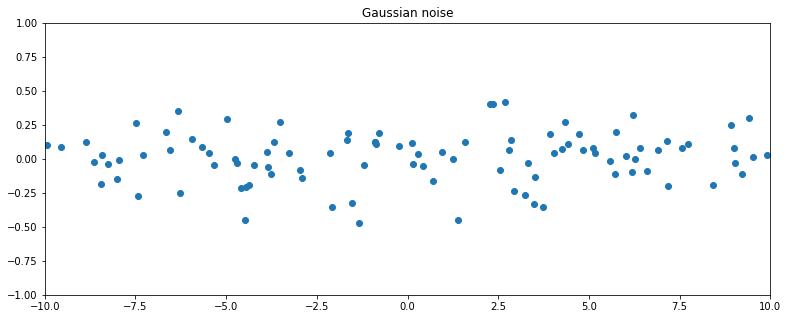

In [5]:
# создадим шум
noise = torch.randn(y_train.shape) / 5.

plt.plot(x_train.numpy(), noise.numpy(), 'o')
plt.axis([-10, 10, -1, 1])
plt.title('Gaussian noise');

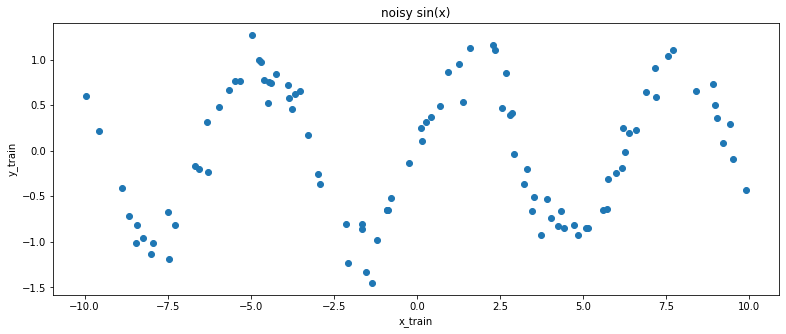

In [6]:
# соединим синус и шум в одно целое
y_train = y_train + noise

plt.plot(x_train.numpy(), y_train.numpy(), 'o')
plt.title('noisy sin(x)')
plt.xlabel('x_train')
plt.ylabel('y_train');

(!) передавая в нейросеть данные, нам хочется, чтобы они были правильной размерности. <b>для общности, нужно наш вектор X (который сейчас строчка), превратить в столбец, у которого в каждой строчке будет одно число X. </b> <br>метод unsqueeze()

In [11]:
x_train.unsqueeze_(1)
y_train.unsqueeze_(1);

#X_train и Y_train изменились, и теперь это столбцы. то есть применили метод unsqueeze_, 
#так как хотим, чтобы каждый элемент был вектором (пусть и из одного числа)

### Validation dataset

возьмём в валидационный датасет просто функцию синуса

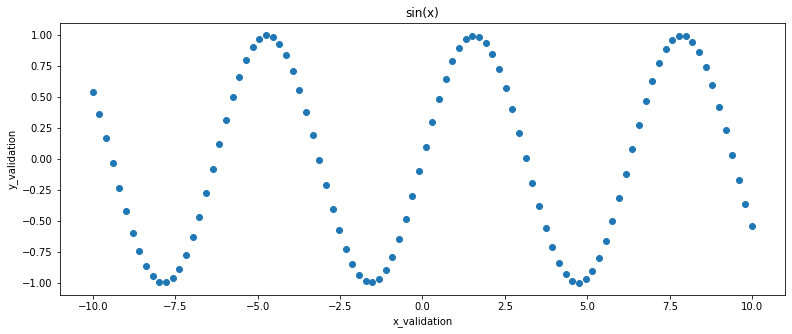

In [9]:
x_validation = torch.linspace(-10, 10, 100)
y_validation = torch.sin(x_validation.data)
plt.plot(x_validation.numpy(), y_validation.numpy(), 'o')
plt.title('sin(x)')
plt.xlabel('x_validation')
plt.ylabel('y_validation');

In [10]:
x_validation.unsqueeze_(1)
y_validation.unsqueeze_(1);

### Model construction

In [12]:
class SineNet(torch.nn.Module): #  наследуем от класса torch.nn.Module
    def __init__(self, n_hidden_neurons):  #  проинициализировать те слои, которые будут использоваться в сети, 
                                           #  n_hidden_neurons - количество скрытых нейронов
        super(SineNet, self).__init__() #  инициализируем родительский объект
        
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons) #  первый слой. "fully connected" слой, то есть полносвязанный слой
                                                        #  передаём количество входных нейронов и количество выходных нейронов.
                                                        #  это, на самом деле, не нейрон будет, а сам вход в нейрон. 
                                                        #  это одно число "x", координата нашей точки, 
                                                        #  по которой что-то предсказывается. 
        self.act1 = torch.nn.Sigmoid() #  функция активации
                                       #  здесь берем сигмоиду. 
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1)  #  добавим ещё один полносвязанный слой, 
                                                         #  у него будет всего один нейрон. 
                                                         #  он будет нашим ответом на вопрос.
                
# В итоге, наша нейросеть будет выглядеть, как два слоя, в одном из них будет несколько нейронов а во втором будет один.

    def forward(self, x): #  функция, которая задает последовательность применения слоев
        
        x = self.fc1(x)   #  применяем слой "fc1", на "x".
        x = self.act1(x)  #  то что получилось мы передаём в функцию активации
        x = self.fc2(x)   #  то что вышло из функций активации мы передаём в "fc2"
        return x          #  это же мы возвращаем



In [32]:
sine_net = SineNet(50)  # создаем сеть, количество скрытых нейронов - 50

### Prediction

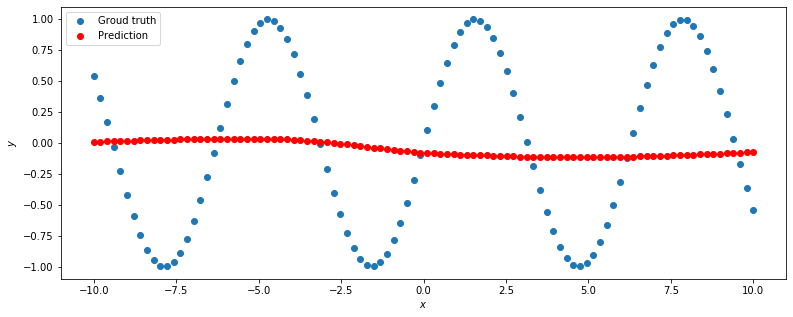

In [28]:
def predict(net, x, y):
    y_pred = net.forward(x) #   вызов метода forward
    #  отрисовка
    plt.plot(x.numpy(), y.numpy(), 'o', label='Groud truth')
    plt.plot(x.numpy(), y_pred.data.numpy(), 'o', c='r', label='Prediction');
    plt.legend(loc='upper left')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    
predict(sine_net, x_validation, y_validation) #  если просто запустить функцию предсказания, выйдет не очень. 
                                              #  но по факту сам предикт работает

Вышло не очень, значит, все-таки обучить придется

### Optimizer

In [29]:
optimizer = torch.optim.Adam(sine_net.parameters(), lr=0.01) #  объект, который будет совершать для нас шаги градиентного спуска
#  в данном случае использован  torch.optim.adam (можно было бы воспользоваться SGD)
#  на вход Adam передаются те параметры, которые мы хотим модифицировать,
#  те параметры, которые мы хотим обучать в нейронной сети, - те веса, 
#  которые хранятся в нейронах (они находятся в sine_net.parameters)
#  второй параметр - "learning rate", шаг градиентного спуска.в данном случае - 0.01

### Loss function

 функция потерь говорит, насколько неправильно мы предсказали, насколько мы ошиблись. 

In [30]:
def loss(pred, target):
    squares = (pred - target) ** 2  #  MSE (mean squared error): предсказание минус таргет в квадрате
    return squares.mean()           #  считаем среднее суммы квадратов

### Training procedure

<b>Понятие эпохи:</b><br>
    возьмём весь наш датасет, прогоним его через нейросеть, получим некоторые предсказания. После этого, на этих предсказаниях посчитаем функцию потерь, которую мы только что задали. После этого у этой функции потерь посчитаем производную и сделаем градиентный шаг.<br>
    <b>Эпоха - это то, что мы посмотрели один раз датасет.

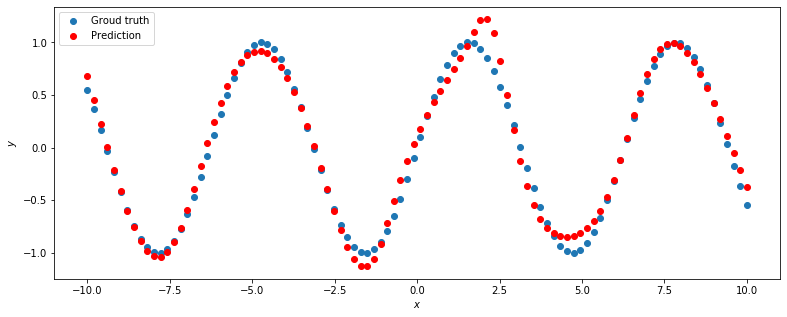

In [31]:
for epoch_index in range(2000):  #  2000 эпох
    optimizer.zero_grad()  #  зануляем градиенты у оптимайзера

    y_pred = sine_net.forward(x_train) #  весь X_train и передаём его в функцию forward и считаем предсказания нейросети
    loss_val = loss(y_pred, y_train)   #  считаем функцию потерь, получаем некоторое число - скаляр

    loss_val.backward()    #  делаем по этому скаляру производную

    optimizer.step()  #  далаем шаг

    
# погнали!
predict(sine_net, x_validation, y_validation)